# mysql connection

In [ ]:
import mysql.connector
connection=mysql.connector.connect(
    host='localhost',     
    user='root',
    password='root',
    database='phonepay'
)
cursor=connection.cursor()

# connecting local mysql with database "phonepay"

In [271]:
cursor.execute("show tables")
for (x,) in cursor:
    print(x)

aggr_insurance
aggr_trans
aggr_user
map_insurance
map_transaction
map_user
top_insurance
top_transaction
top_user


# FUNCTION EXTRACT_DATA

In [ ]:
def extract_transaction_data(path):
  import os
  import json
  agg_state_list=os.listdir(path)

  for state in agg_state_list:
    p_state=os.path.join(path,state)
    agg_year_list=os.listdir(p_state)

    for year in agg_year_list:
      p_year=os.path.join(p_state,year)
      agg_quater_list=os.listdir(p_year)

      for quater in agg_quater_list:
        p_quater=os.path.join(p_year,quater)
        
        with open (p_quater,'r')as data:
          D=json.load(data)
        yield state,year,int(quater.strip(".json")),D    # yield each set(state,year,quater,data) at a time
        data.close()

In [ ]:
# function to convert dataframe to list using numpy

def get_list_values(values): 
    import numpy
    value=[tuple(x) for x in values.to_numpy()]
    return(value)

# EXTRACT DATA

##  1*1 agrregated/transaction

In [ ]:
# 1*1 aggregated\transaction
path= r"G:\python\pulse\data\aggregated\transaction\country\india\state"
import pandas as pd
clm={'State':[], 'Year':[],'Quater':[],'Transacion_type':[], 'Transacion_count':[], 'Transacion_amount':[]}

query ="""create table if not exists aggr_trans (
State varchar(100),
Year int,
Quarter int,
Transaction_type varchar(100),
Transaction_count Bigint,
Transaction_amount bigint,
constraint pk_aggr_trans primary key(State,Year,Quarter,Transaction_type)
)
"""
cursor.execute(query)
# primary key ((State,Year,Quarter,Transaction_type))  avoid repetation 


for state,year,quater,D in extract_transaction_data(path):

  # if D.get('data') and D['data'].get('transactionData') is not None:
  user_data=D.get("data",{}).get("transactionData")
  if user_data:

    for z in D['data']['transactionData']:
      clm['State'].append(state)
      clm['Year'].append(year)
      clm['Quater'].append(quater)

      Transacion_type=z['name']
      count=z['paymentInstruments'][0]['count']
      amount=z['paymentInstruments'][0]['amount']
      clm['Transacion_type'].append(Transacion_type)
      clm['Transacion_count'].append(count)
      clm['Transacion_amount'].append(int(amount))

aggr_trans=pd.DataFrame(clm)  
#aggr_trans


In [285]:
query ="insert ignore into aggr_trans (State, Year, Quarter, Transaction_type ,Transaction_count,Transaction_amount) values(%s,%s,%s,%s,%s,%s)"
values=get_list_values(aggr_trans)  # function call (df to numpy)
cursor.executemany(query,values)
connection.commit()

# dataframe to mysql 

In [ ]:
# check for both df and mysql rows are equal

cursor.execute('SELECT * FROM aggr_trans')
rows = cursor.fetchall()
print(f'No of rows of mysql :{len(rows)}','\n',f'No of rows of df :{len(aggr_trans)}')

No of rows of mysql :5034 
 No of rows of df :5034


## 1*2 aggregated/user/

In [ ]:
# 1*2 aggregated/user/



      # Check if 'data' and 'usersByDevice' exist and are not None

                  #   if D.get('data') and D['data'].get('usersByDevice') is not None:

      # this code help in getting non null data avoid error



path =r"G:\python\pulse\data\aggregated\user\country\india\state"
clm={'state':[],'year':[],'quater':[],'brand':[],'count':[],'percentage':[]}
clm1={'state':[],'year':[],'quater':[],'registeredUsers':[],"appOpens":[]}

query="""CREATE TABLE if not exists aggr_user 
(
    state      VARCHAR(100),
    year       INT,
    quater     INT,
    brand      VARCHAR(100),
    count      INT,
    percentage FLOAT,
    CONSTRAINT pk_aggr_user PRIMARY KEY (state, year, quater, brand)
) """
cursor.execute(query)


import pandas as pd
for state,year,quater,D in extract_transaction_data(path):
      user_data=D['data']['usersByDevice']
      if user_data:
        for z in user_data:
          clm['state'].append(state)
          clm['year'].append(year)
          clm['quater'].append(quater)

          clm['brand'].append(z['brand'])
          clm['count'].append(z['count'])
          clm['percentage'].append(f"{z['percentage'] * 100:.2f}%")

      user_data=D['data']['aggregated']

      clm1['state'].append(state)
      clm1['year'].append(year)
      clm1['quater'].append(quater)

      clm1['registeredUsers'].append(user_data['registeredUsers'])
      clm1['appOpens'].append(user_data['appOpens'])

aggre_user_usersByDevice=pd.DataFrame(clm)
aggre_user_aggregated=pd.DataFrame(clm1)
#aggre_user_usersByDevice
#aggre_user_aggregated


In [9]:
query ='insert ignore into aggr_user (state,year,quater,brand,count,percentage) values(%s,%s,%s,%s,%s,%s)'
cursor.executemany(query,get_list_values(aggre_user_usersByDevice))
connection.commit()

## 1*3 aggregated/insurance

In [11]:
# 1*3 aggregated/insurance

path=r"G:\python\pulse\data\aggregated\insurance\country\india\state"
clm = {'state':[],'year':[],'quater':[],'type':[],'count':[],'amount':[]}
query=""" create table if not exists aggr_insurance (
  state varchar(255),
  year int,
  quater int,
  type varchar(255),
  count int,
  amount int,
  constraint pk primary key (state,year,quater,type)
)
"""
cursor.execute(query)

for state,year,quater,D in extract_transaction_data(path):

        user_data=D['data']['transactionData']
        #user_data=D.get('data',{}).get('transactionData')
        if user_data:
          for z in user_data:
            clm['state'].append(state)
            clm['year'].append(year)
            clm['quater'].append(quater)

            clm['type'].append(z['paymentInstruments'][0]['type'])
            clm['count'].append(z['paymentInstruments'][0]['count'])
            clm['amount'].append(z['paymentInstruments'][0]['amount'])

aggre_insurance=pd.DataFrame(clm)
#aggre_insurance

In [12]:
query="insert ignore into aggr_insurance(state,year,quater,type,count,amount) values(%s,%s,%s,%s,%s,%s)"
cursor.executemany(query,get_list_values(aggre_insurance))
connection.commit()

In [13]:
cursor.execute("select count(*) from aggr_insurance")
rows=cursor.fetchone()[0]
rows

682

## 2*1 map/insurance

In [14]:
# 2*1 map/insurance

path = r"G:\python\pulse\data\map\insurance\country\india\state"
clm = {'state':[],'year':[],'quater':[],'lat':[],'lng':[],'metric':[],'label':[]}

query=""" create table if not exists map_insurance (
  state varchar(255),
  year int,
  quater int,
  lat float,
  lng float,
  metric int,
  label varchar(255),
  constraint pk primary key (state,year,quater)
  )
"""
cursor.execute(query)

for state,year,quater,D in extract_transaction_data(path):
        user_data=D['data']['data']['data']
        if user_data:

          for z in user_data:
            clm['state'].append(state)
            clm['year'].append(year)
            clm['quater'].append(quater)

            clm['lat'].append(float(z[0]))
            clm['lng'].append(float(z[1]))
            clm['metric'].append(z[2])
            clm['label'].append(z[3])

map_insurance=pd.DataFrame(clm)
#map_insurance

In [15]:
query=""" create table if not exists map_insurance (
  state varchar(255),
  year int,
  quater int,
  lat float,
  lng float,
  metric int,
  label varchar(255)
  )
"""
cursor.execute(query)

In [16]:
map_insurance.head()

,state,year,quater,lat,lng,metric,label
0,andaman-&-nicobar-islands,2020,2,9.173490,92.812846,3.0,nicobars district
1,andaman-&-nicobar-islands,2020,2,11.665257,92.753094,2.0,south andaman district
2,andaman-&-nicobar-islands,2020,2,11.665446,92.733193,1.0,south andaman district
3,andaman-&-nicobar-islands,2020,3,11.653981,92.743142,8.0,south andaman district
4,andaman-&-nicobar-islands,2020,3,11.654075,92.723246,8.0,south andaman district


In [17]:
query="insert ignore into map_insurance(state,year,quater,lat,lng,metric,label) values(%s,%s,%s,%s,%s,%s,%s)"
cursor.executemany(query,get_list_values(map_insurance))
connection.commit()

OperationalError: 2055: Lost connection to MySQL server at 'localhost:3306', system error: Errno 10054: An existing connection was forcibly closed by the remote host

## 2*2 map/transaction/

In [22]:
# 2*2 map/transaction/

path=r"G:\python\pulse\data\map\transaction\hover\country\india\state"
clm = {'state':[],'year':[],'quater':[],'dist_name':[],'type':[],'count':[],'ammount':[]}
query=""" create table if not exists map_transaction (
  state varchar(255),
  year int,
  quater int,
  dist_name varchar(255),
  type varchar(255),
  count int,
  ammount int,
  constraint pk primary key (state,year,quater,dist_name,type)
  )
"""
cursor.execute(query)
for state,year,quater,D in extract_transaction_data(path):
        user_data=D['data']['hoverDataList']
        # data is in list[list[data]] so use for loop to extract data
        for x in user_data:
          for y in x['metric']:
            clm['state'].append(state)
            clm['year'].append(year)
            clm['quater'].append(quater)

            clm['dist_name'].append(x['name'])
            clm['type'].append(y['type'])
            clm['count'].append(y['count'])
            clm['ammount'].append(int(y['amount']))

map_transaction=pd.DataFrame(clm)
#map_transaction

In [23]:
query="insert ignore into map_transaction(state,year,quater,dist_name,type,count,ammount) values(%s,%s,%s,%s,%s,%s,%s)"
cursor.executemany(query,get_list_values(map_transaction))
connection.commit()

In [24]:
df=pd.read_sql(f"select * from map_transaction",connection)
if len(df)==len(map_transaction):
    print(len(df))
else:
    print("error")

C:\Users\aravindan\AppData\Local\Temp\ipykernel_11948\3939646936.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(f"select * from map_transaction",connection)


20604


## 2*3 map/user

In [25]:
# 2*3 map/user

path=r"G:\python\pulse\data\map\user\hover\country\india\state"

clm = {'state':[],'year':[],'quater':[],'dist_name':[],'registeredUsers':[],'appOpen':[]}
query=""" create table if not exists map_user (
  state varchar(255),
  year int,
  quater int,
  dist_name varchar(255),
  registeredUsers int,
  appOpen int,
  constraint pk primary key (state,year,quater,dist_name)
  )
"""
cursor.execute(query)
for state,year,quater,D in extract_transaction_data(path):
        user_data=D['data']['hoverData']
        # data is in list[list[data]] so use for loop to extract data

        for dist_name,metrics in user_data.items():
          registereduser=metrics['registeredUsers']
          appOpen=metrics['appOpens']
          clm['state'].append(state)
          clm['year'].append(year)
          clm['quater'].append(quater)
          clm['dist_name'].append(dist_name)
          clm['registeredUsers'].append(registereduser)
          clm['appOpen'].append(appOpen)


map_user=pd.DataFrame(clm)
#map_user


In [26]:
query="insert ignore into map_user(state,year,quater,dist_name,registeredUsers,appOpen) values(%s,%s,%s,%s,%s,%s)"
cursor.executemany(query,get_list_values(map_user))
connection.commit()

## 3*1 top/insurance

In [27]:
# 3*1 top/insurance
path = r"G:\python\pulse\data\top\insurance\country\india\state"
clm = {'state':[],'year':[],'quater':[],'dist_name':[],'count':[],'ammount':[] }
query=""" create table if not exists top_insurance (
  state varchar(255),
  year int,
  quater int,
  dist_name varchar(255),
  count int,
  ammount int,
  constraint pk primary key (state,year,quater,dist_name)
  )
"""
cursor.execute(query)

for state,year,quater,D in extract_transaction_data(path):
        user_data=D['data']['districts']
        for dist in user_data:

          clm['state'].append(state)
          clm['year'].append(year)
          clm['quater'].append(quater)

          clm['dist_name'].append(dist['entityName'])
          clm['count'].append(dist['metric']['count'])
          clm['ammount'].append(dist['metric']['amount'])

top_insurance=pd.DataFrame(clm)
#top_insurance



In [28]:
query="insert ignore into top_insurance(state,year,quater,dist_name,count,ammount) values(%s,%s,%s,%s,%s,%s)"
cursor.executemany(query,get_list_values(top_insurance))
connection.commit()


## 3*2  top/transaction

In [29]:
# 3*2  top/transaction

path =r"G:\python\pulse\data\top\transaction\country\india\state"
clm = {'state':[],'year':[],'quater':[],'dist_name':[],'count':[],'trans_amount':[]}

query=""" create table if not exists top_transaction (
  state varchar(255),
  year int,
  quater int,
  dist_name varchar(255),
  count int,
  trans_amount int,
  constraint pk primary key (state,year,quater,dist_name)
  )
"""
cursor.execute(query)

for state,year,quater,D in extract_transaction_data(path):
        user_data=D['data']['districts']
        for x in user_data:

          clm['state'].append(state)
          clm['year'].append(year)
          clm['quater'].append(quater)

          clm['count'].append(x['metric']['count'])
          clm['trans_amount'].append(int(x['metric']['amount']))
          clm['dist_name'].append(x['entityName'])

top_transaction=pd.DataFrame(clm)
#top_transaction


In [30]:
query="insert ignore into top_transaction(state,year,quater,dist_name,count,trans_amount) values(%s,%s,%s,%s,%s,%s)"
cursor.executemany(query,get_list_values(top_transaction))
connection.commit()

## 3*3 top/user

In [269]:
# 3*3 top/user

path=r"G:\python\pulse\data\top\user\country\india\state"
clm = {'state':[],'year':[],'quater':[],'pincode':[],'registeredUsers':[]}

query=""" create table if not exists top_user (
  state varchar(255),
  year int,
  quater int,
  pincode int,
  registeredUsers int,
  constraint pk primary key (state,year,quater,pincode)
  )
"""
cursor.execute(query)

for state,year,quater,D in extract_transaction_data(path):
        user_data=D['data']['pincodes']
        for x in user_data:

          clm['state'].append(state)
          clm['year'].append(year)
          clm['quater'].append(quater)

          clm['pincode'].append(x['name'])
          clm['registeredUsers'].append(x['registeredUsers'])

top_user=pd.DataFrame(clm)
#top_user



In [270]:
query="insert ignore into top_user(state,year,quater,pincode,registeredUsers) values(%s,%s,%s,%s,%s)"
cursor.executemany(query,get_list_values(top_user))
connection.commit()


# plot  visualisation


## 0. functions data pandas

In [273]:
import pandas as pd

cursor.execute("SHOW TABLES")
tables = cursor.fetchall()

for (table_name,) in tables:
    print(f"Loading table: {table_name}")
    globals()[table_name] = pd.read_sql(f"SELECT * FROM `{table_name}`", connection)



Loading table: aggr_insurance


C:\Users\aravindan\AppData\Local\Temp\ipykernel_14064\58676890.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  globals()[table_name] = pd.read_sql(f"SELECT * FROM `{table_name}`", connection)


Loading table: aggr_trans
Loading table: aggr_user
Loading table: map_insurance
Loading table: map_transaction


C:\Users\aravindan\AppData\Local\Temp\ipykernel_14064\58676890.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  globals()[table_name] = pd.read_sql(f"SELECT * FROM `{table_name}`", connection)


Loading table: map_user
Loading table: top_insurance
Loading table: top_transaction
Loading table: top_user


In [107]:
top_user

,state,year,quater,dist_name,registeredUsers
0,andaman-&-nicobar-islands,2018,1,744101,1108
1,andaman-&-nicobar-islands,2018,1,744102,1006
2,andaman-&-nicobar-islands,2018,1,744103,1608
3,andaman-&-nicobar-islands,2018,1,744104,272
4,andaman-&-nicobar-islands,2018,1,744105,1075
...,...,...,...,...,...
18291,west-bengal,2024,4,north twenty four parganas,5085095
18292,west-bengal,2024,4,paschim bardhaman,1468252
18293,west-bengal,2024,4,paschim medinipur,1522845
18294,west-bengal,2024,4,purba medinipur,1717074


## 1. agggregate Trasaction input

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

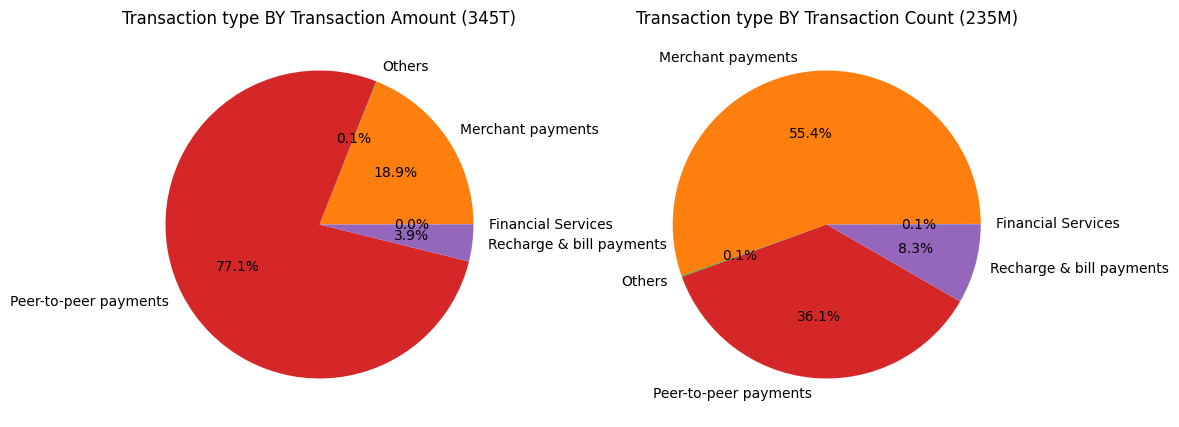

In [7]:
fig,axis=plt.subplots(1,2,figsize=(12,5))
total_amount=aggr_trans['Transaction_amount'].sum()
chart1=aggr_trans.groupby(['Transaction_type'])['Transaction_amount'].sum()
axis[0].pie(
    chart1,
    labels=chart1.index,
    autopct='%1.1f%%'

)
axis[0].set_title(f'Transaction type BY Transaction Amount ({int(total_amount/1000000000000)}T)')

chart2=aggr_trans.groupby(['Transaction_type'])['Transaction_count'].sum()
total_count=aggr_trans['Transaction_count'].sum()
axis[1].pie(
    chart2,
    labels=chart2.index,
    autopct='%1.1f%%'
)
axis[1].set_title(f"Transaction type BY Transaction Count ({int(total_count/1000000000)}M)")
plt.show()

1. by transaction amount peer-to-peer is max
2. by transaction count merchant is max

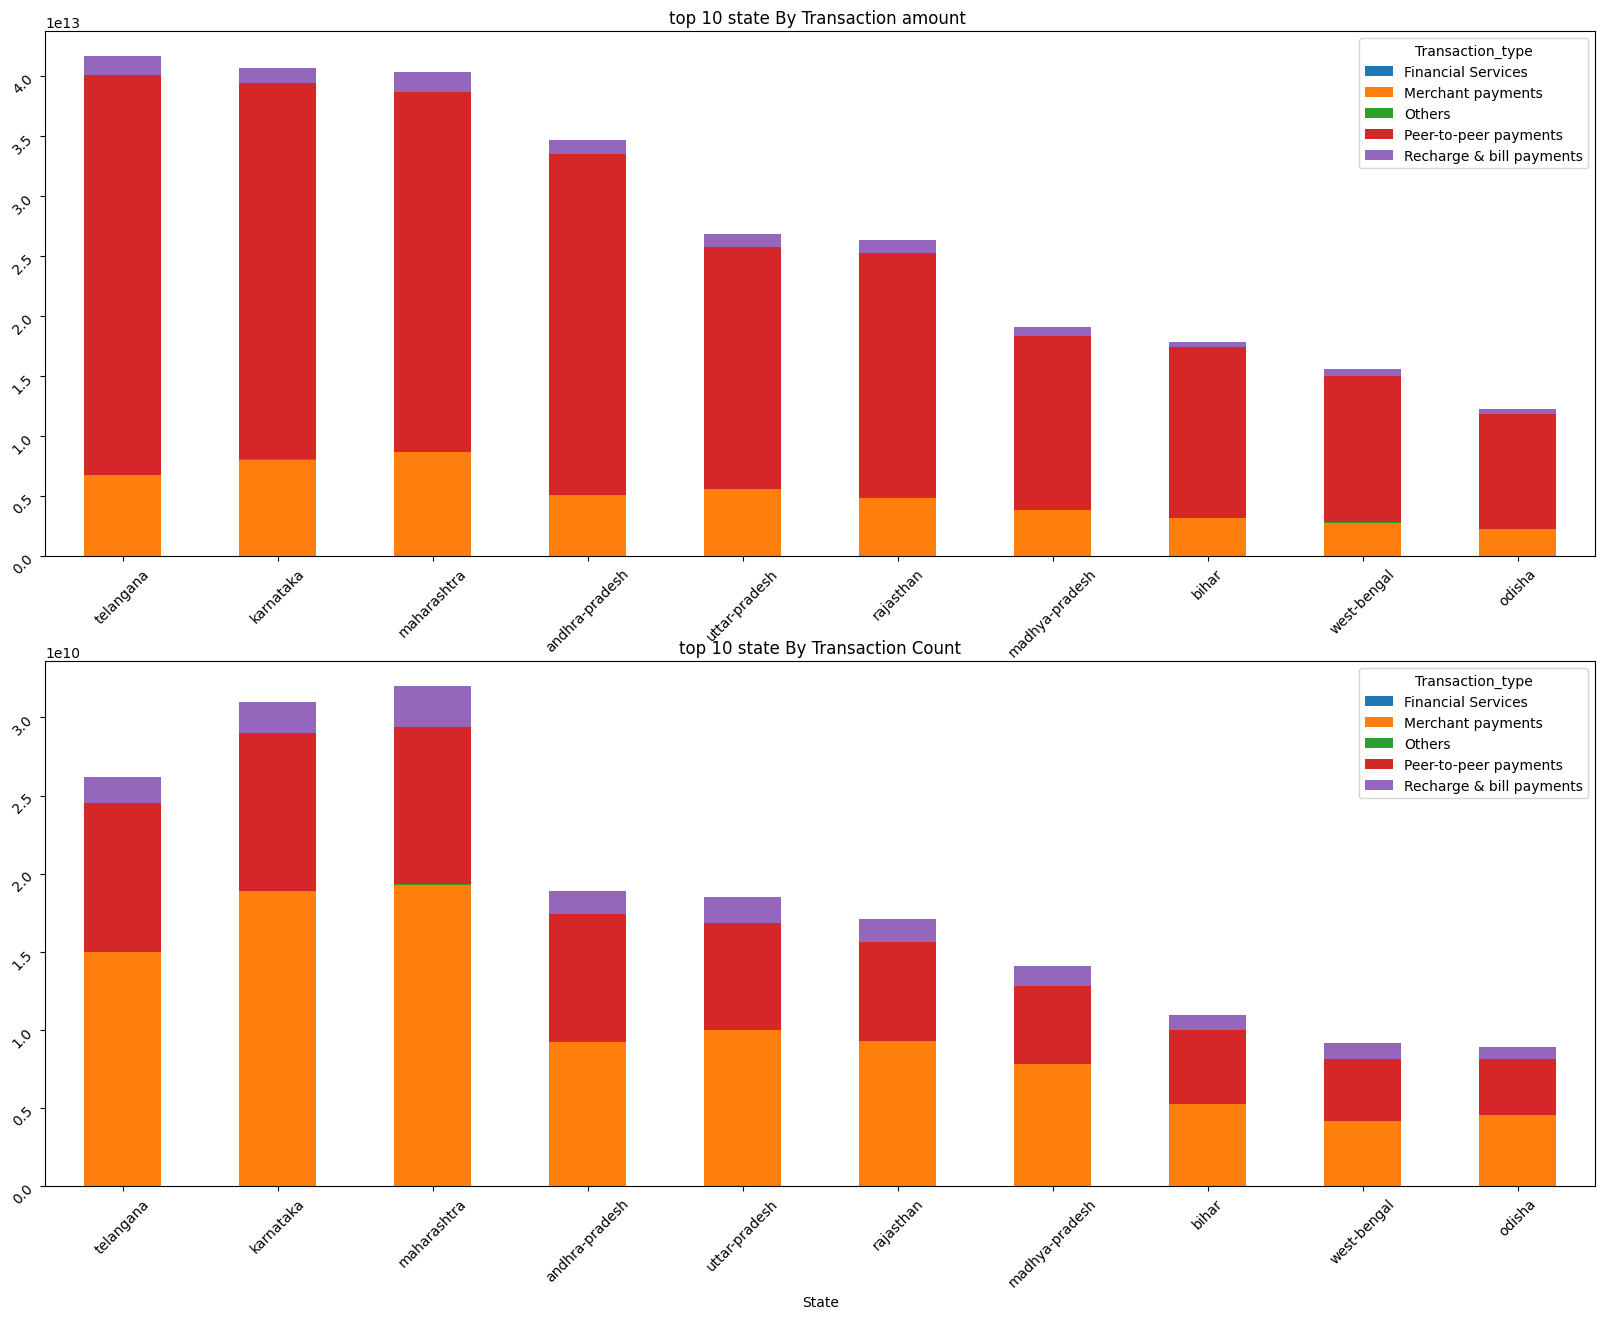

In [8]:
fig,a=plt.subplots(2,1,figsize=(20,15))

state_total=aggr_trans.groupby(['State'])['Transaction_amount'].sum().sort_values(ascending=False).head(10)
sorted_state=state_total.index.tolist()

df=aggr_trans.groupby(['State','Transaction_type'])['Transaction_amount'].sum().unstack()
df=df.reindex(sorted_state)
df.plot(kind='bar',stacked=True,ax=a[0])
a[0].set_title("top 10 state By Transaction amount ")
a[0].tick_params(rotation=45)

df1=aggr_trans.groupby(['State','Transaction_type'])['Transaction_count'].sum().unstack()
df1=df1.reindex(sorted_state)
df1.plot(kind='bar',ax=a[1],stacked=True)
a[1].set_title("top 10 state By Transaction Count")
a[1].tick_params(rotation=45)
plt.show()

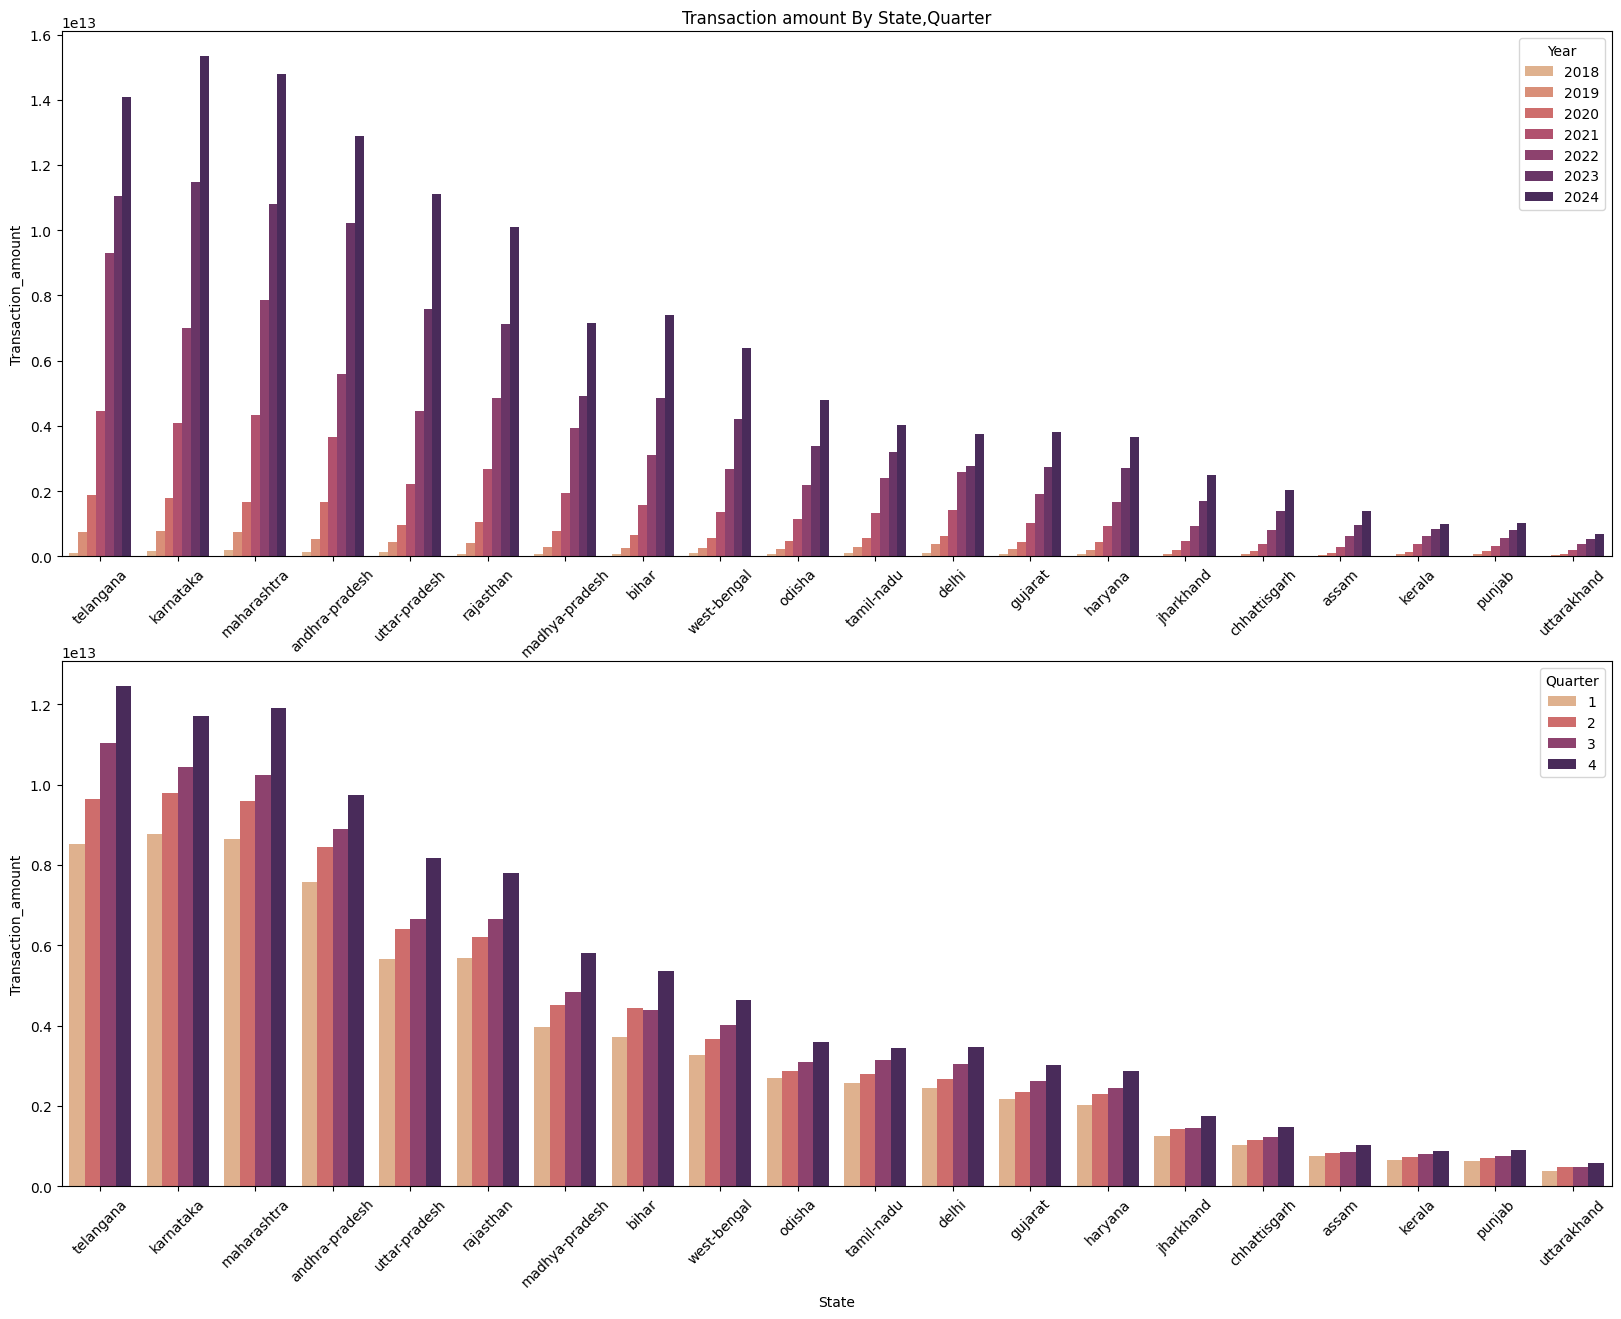

In [9]:
fig,a=plt.subplots(2,1,figsize=(20,15))
sorted_state=aggr_trans.groupby(['State'])['Transaction_amount'].sum().sort_values(ascending=False).head(20).index.tolist()
chart1=aggr_trans.groupby(['State','Year'])['Transaction_amount'].sum().reset_index()
sns.barplot(
    x='State',
    y='Transaction_amount',
    data=chart1,
    hue='Year',
    ax=a[0],
    palette='flare',
    order=sorted_state
)
a[0].tick_params(axis='x',rotation=45)
a[0].set_title("Transaction amount By State,year")
chart2=aggr_trans.groupby(['State','Quarter'])['Transaction_amount'].sum().reset_index()
sns.barplot(
    data=chart2,
    x='State',
    y='Transaction_amount',
    hue='Quarter',
    palette='flare',
    order=sorted_state
)
a[1].tick_params(axis='x',rotation=45)
a[0].set_title("Transaction amount By State,Quarter")
#a[0].set_yscale('log')
plt.show()

In [10]:
top_transaction.head()

,state,year,quater,dist_name,count,trans_amount
0,andaman-&-nicobar-islands,2018,1,nicobars,528,1139848
1,andaman-&-nicobar-islands,2018,1,north and middle andaman,442,931663
2,andaman-&-nicobar-islands,2018,1,south andaman,5688,12560249
3,andaman-&-nicobar-islands,2018,2,nicobars,1120,3072436
4,andaman-&-nicobar-islands,2018,2,north and middle andaman,825,1317863


In [11]:
df=top_transaction
df['density']=df['trans_amount']/df['count']
df.sort_values(by='density',ascending=False)

,state,year,quater,dist_name,count,trans_amount,density
5110,mizoram,2018,2,saiha,846,5346759,6320.046099
5126,mizoram,2018,4,saiha,1299,7552316,5813.946112
5109,mizoram,2018,2,mamit,1813,10477582,5779.140651
5118,mizoram,2018,3,saiha,1060,6004487,5664.610377
5101,mizoram,2018,1,mamit,1133,5729263,5056.719329
...,...,...,...,...,...,...,...
3565,karnataka,2023,4,bengaluru urban,1345789742,2147483647,1.595705
3575,karnataka,2024,1,bengaluru urban,1410557938,2147483647,1.522436
3585,karnataka,2024,2,bengaluru urban,1497173080,2147483647,1.434359
3595,karnataka,2024,3,bengaluru urban,1631451937,2147483647,1.316302


## 2. Device Dominance and User Engagement Analysis

In [12]:
aggr_user.head()
top_user.head().sort_values(by='registeredUsers',ascending=False)

,state,year,quater,dist_name,registeredUsers
2,andaman-&-nicobar-islands,2018,1,south andaman,5846
4,andaman-&-nicobar-islands,2018,2,north and middle andaman,911
1,andaman-&-nicobar-islands,2018,1,north and middle andaman,632
3,andaman-&-nicobar-islands,2018,2,nicobars,351
0,andaman-&-nicobar-islands,2018,1,nicobars,262


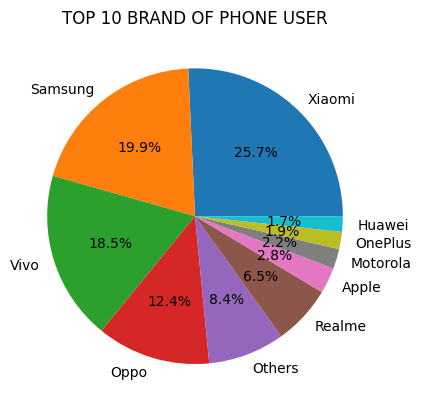

In [13]:
df=aggr_user.groupby(['brand'])['count'].sum().sort_values(ascending=False).head(10)
plt.pie(
    df,
    labels=df.index,
    autopct='%1.1f%%'
)
plt.title("TOP 10 BRAND OF PHONE USER")
plt.show()

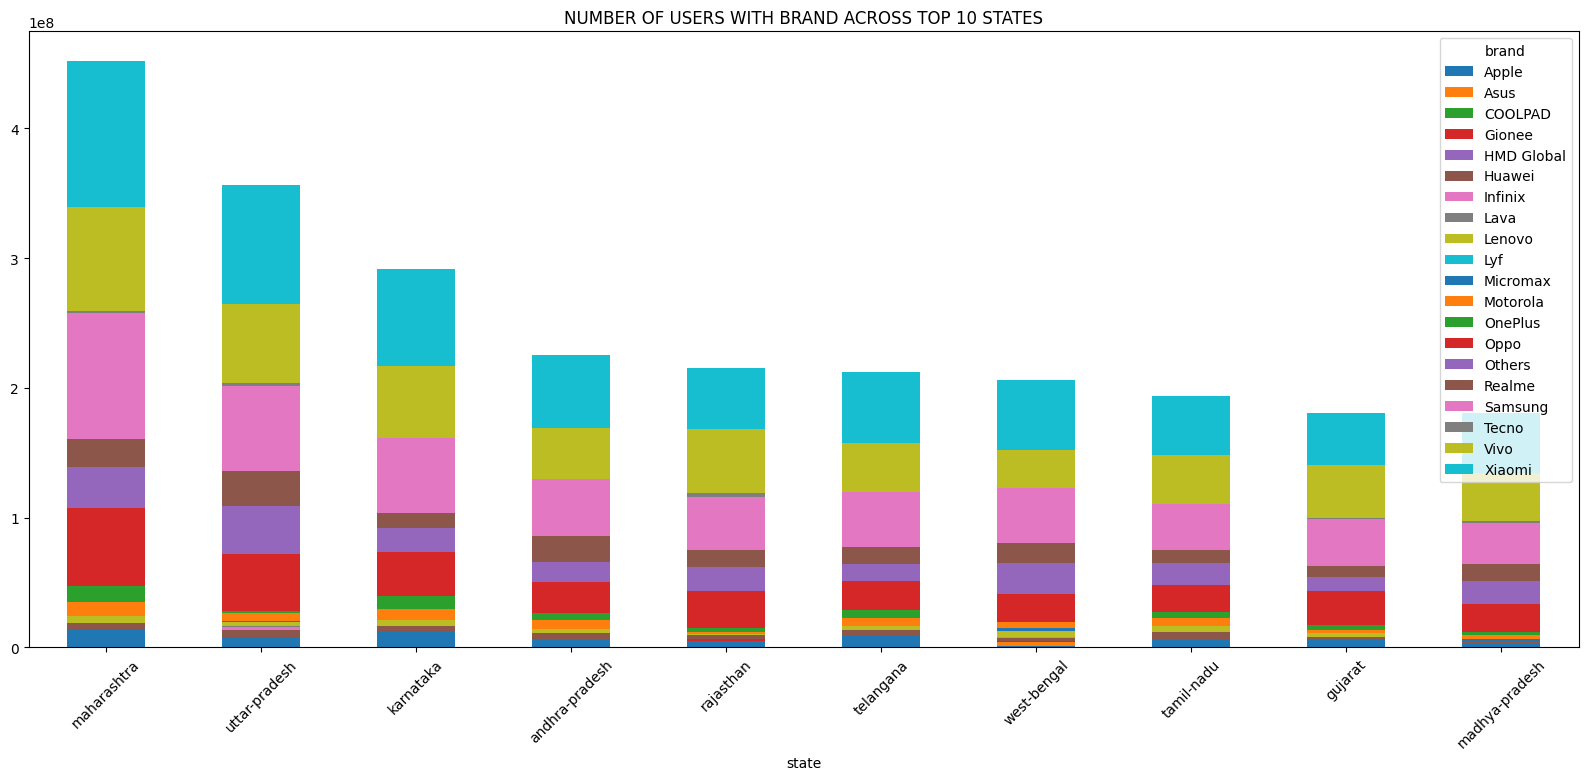

In [14]:
df=aggr_user
state_list=df.groupby(['state'])['count'].sum().sort_values(ascending=False).head(10)
sorted=state_list.index.tolist()
df=df.groupby(['state','brand'])['count'].sum().unstack()
df=df.reindex(sorted)
df.plot(kind='bar',stacked=True,figsize=(20,8))
plt.xticks(rotation=45)
plt.title("NUMBER OF USERS WITH BRAND ACROSS TOP 10 STATES")
plt.show()

## 3. Insurance Penetration and Growth Potential Analysis

In [15]:
aggr_insurance.head()


,state,year,quater,type,count,amount
0,andaman-&-nicobar-islands,2020,2,TOTAL,6,1360
1,andaman-&-nicobar-islands,2020,3,TOTAL,41,15380
2,andaman-&-nicobar-islands,2020,4,TOTAL,124,157975
3,andaman-&-nicobar-islands,2021,1,TOTAL,225,244266
4,andaman-&-nicobar-islands,2021,2,TOTAL,137,181504


Text(0.5, 0, 'STATE CLUSTERED (QUATER)')

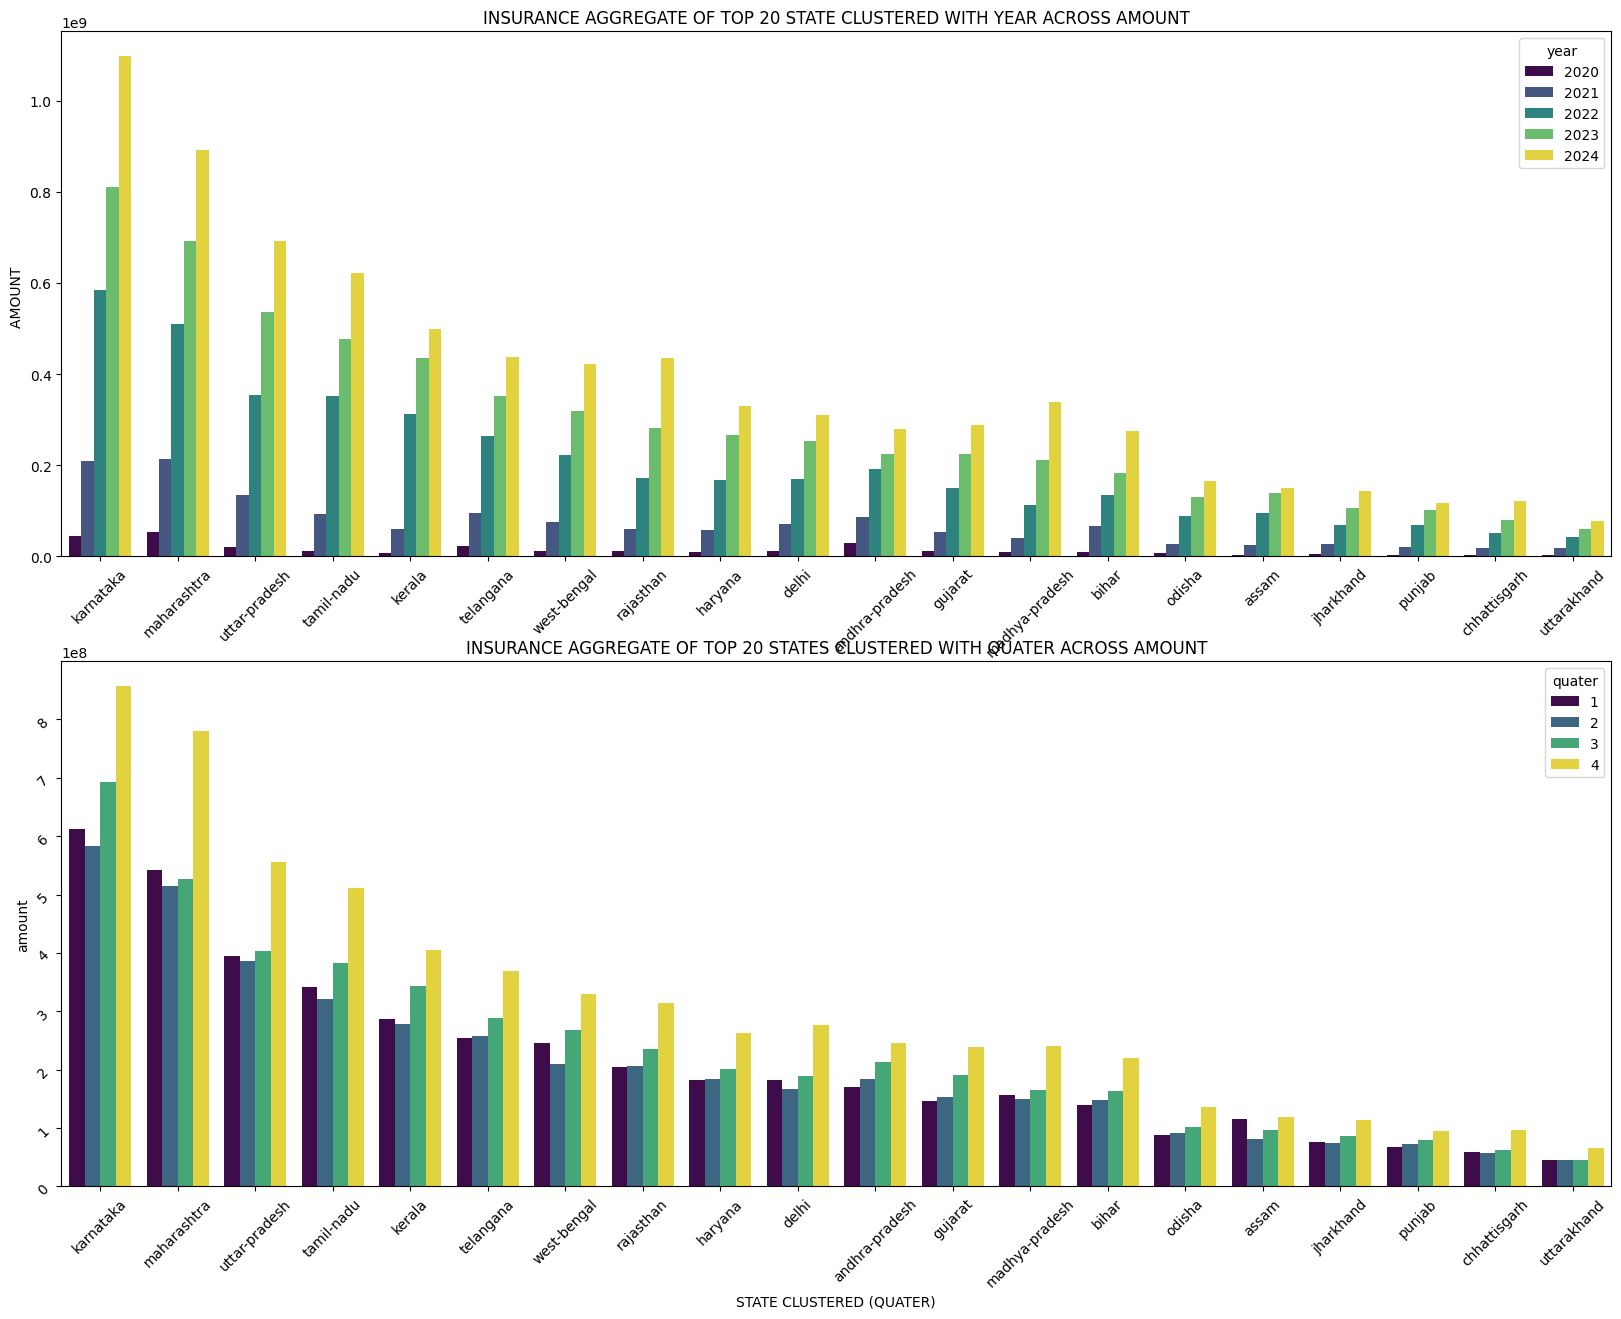

In [16]:
df=aggr_insurance
fig,a=plt.subplots(2,1,figsize=(20,15))
sorted=df.groupby(['state'])['amount'].sum().sort_values(ascending=False).head(20).index.tolist()

chart1=df.groupby(['state','year'])['amount'].sum().reset_index()
sns.barplot(
    data=chart1,
    x='state',
    y='amount',
    hue='year',
    order=sorted,
    palette='viridis',
    ax=a[0]
)
a[0].tick_params(rotation=45,axis='x')
a[0].set_title("INSURANCE AGGREGATE OF TOP 20 STATE CLUSTERED WITH YEAR ACROSS AMOUNT")
a[0].set_xlabel("STATE CLUSTERED(YEAR)")
a[0].set_ylabel("AMOUNT ")

df=aggr_insurance

chart2=df.groupby(['state','quater'])['amount'].sum().reset_index()
sns.barplot(
    data=chart2,
    ax=a[1],
    palette='viridis',
    x='state',
    y='amount',
    hue='quater',
    order=sorted
)
a[1].tick_params(rotation=45)
a[1].set_title("INSURANCE AGGREGATE OF TOP 20 STATES CLUSTERED WITH QUATER ACROSS AMOUNT")
a[1].set_xlabel("STATE CLUSTERED (QUATER)")


In [17]:
top_insurance.head()

,state,year,quater,dist_name,count,ammount
0,andaman-&-nicobar-islands,2020,2,nicobars,3,565
1,andaman-&-nicobar-islands,2020,2,south andaman,3,795
2,andaman-&-nicobar-islands,2020,3,nicobars,5,1448
3,andaman-&-nicobar-islands,2020,3,north and middle andaman,1,281
4,andaman-&-nicobar-islands,2020,3,south andaman,35,13651


## 4. Transaction Analysis for Market Expansion

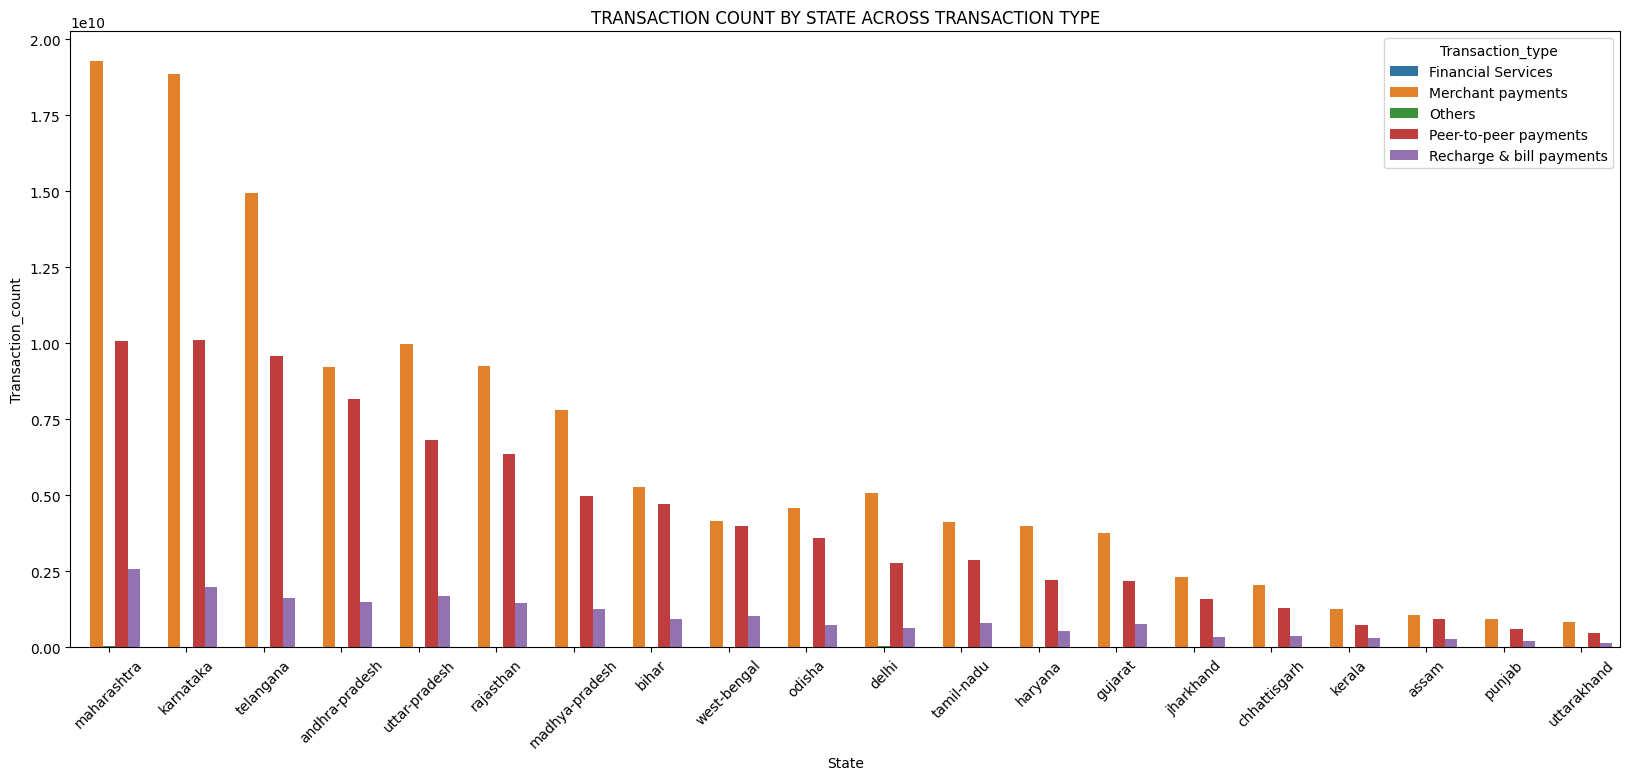

'\nmerchhant payment in karnataka,maharastra is high that telegana\nfinancial services , others is no nominal \nmerhcant , peer to peer is to tirivial \nrecharged payement to increasse count reduce the quantum so they may recharge frequently \n'

In [72]:
df=aggr_trans
plt.figure(figsize=(20,8))
chart1=df1.groupby(['State','Transaction_type'])['Transaction_count'].sum().reset_index()
sorted=df1.groupby(['State'])['Transaction_count'].sum().sort_values(ascending=False).head(20).index.tolist()
sns.barplot(
    data=chart1,
    x='State',
    y='Transaction_count',
    hue='Transaction_type',
    order=sorted
)
plt.xticks(rotation=45)
plt.title("TRANSACTION COUNT BY STATE ACROSS TRANSACTION TYPE")
plt.show()

'''
merchhant payment in karnataka,maharastra is high that telegana
financial services , others is no nominal 
merhcant , peer to peer is to tirivial 
recharged payement to increasse count reduce the quantum so they may recharge frequently 
'''

C:\Users\aravindan\AppData\Local\Temp\ipykernel_14064\3981620095.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  largest = agg.groupby('state', group_keys=False).apply(lambda x: x.nlargest(1, 'ammount'))
C:\Users\aravindan\AppData\Local\Temp\ipykernel_14064\3981620095.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  smallest = agg.groupby('state', group_keys=False).apply(lambda x: x.nsmallest(1, 'amm

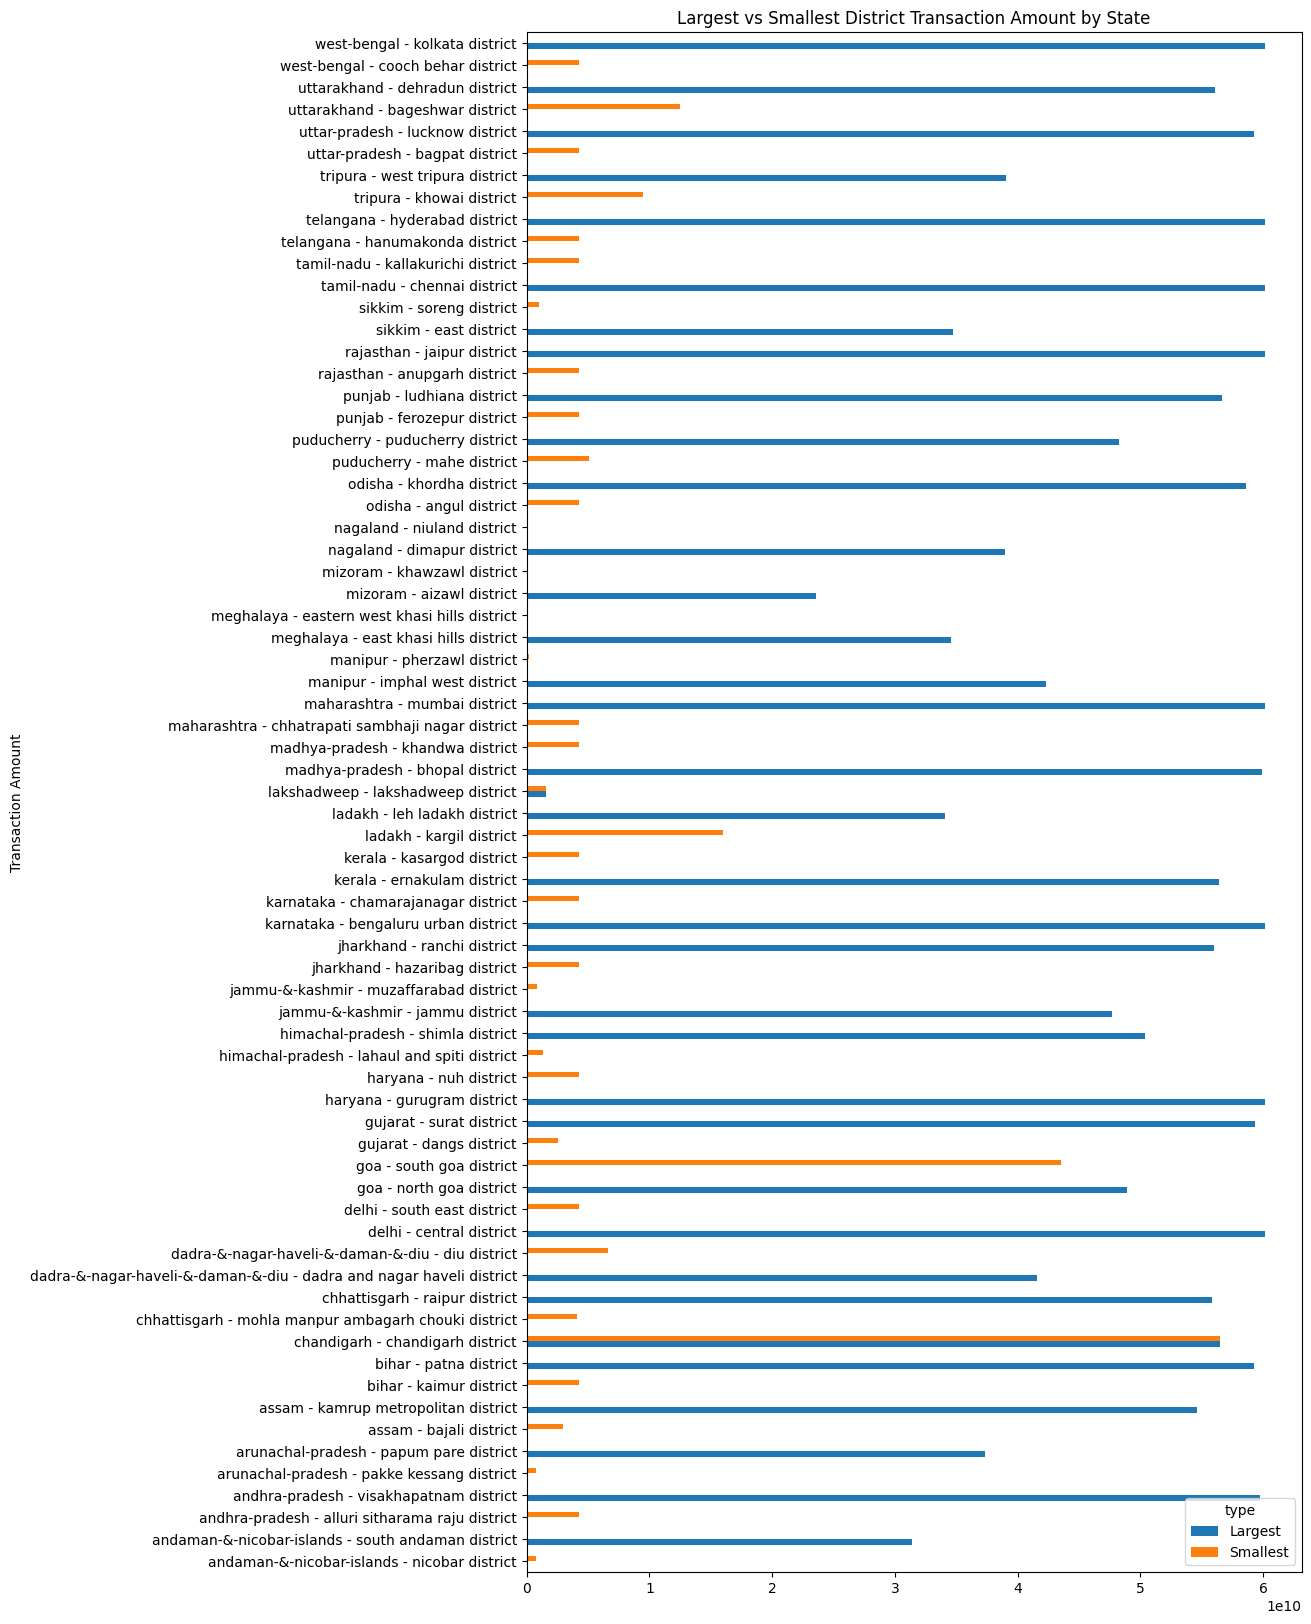

In [79]:
df2 = map_transaction.drop(['type'], axis=1)
agg = df2.groupby(['state', 'dist_name'])['ammount'].sum().reset_index()

largest = agg.groupby('state', group_keys=False).apply(lambda x: x.nlargest(1, 'ammount'))
smallest = agg.groupby('state', group_keys=False).apply(lambda x: x.nsmallest(1, 'ammount'))

largest['type'] = 'Largest'
smallest['type'] = 'Smallest'

combined = pd.concat([largest, smallest])

combined['label'] = combined['state'] + ' - ' + combined['dist_name']
pivot = combined.pivot(index='label', columns='type', values='ammount').fillna(0)

pivot.plot(kind='barh', figsize=(10, 20))

plt.ylabel('Transaction Amount')
plt.title('Largest vs Smallest District Transaction Amount by State')

plt.show()


## 8. User Registration Analysis

C:\Users\aravindan\AppData\Local\Temp\ipykernel_14064\1624420239.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(path)


,District,pincode
0,ANANTAPUR,515631
1,ANANTAPUR,515631
2,ANANTAPUR,515631
3,ANANTAPUR,515581
4,ANANTAPUR,515581
...,...,...
157121,MEERUT,250002
157122,MEERUT,250002
157123,MEERUT,250001
157124,KOZHIKODE,673611


In [284]:
path=r'G:\python\pincode.csv'       # pincodes in india file csv
import pandas as pd
df=pd.read_csv(path)
df.drop(['CircleName', 'RegionName', 'DivisionName', 'StateName','OfficeName','OfficeType', 'Delivery', 'Latitude','Longitude'],axis=1,inplace=True)
df['pincode']=df['Pincode']
df.drop(['Pincode'],axis=1,inplace=True)

com=pd.merge(top_user,df,on='pincode',how='inner')
com=com.drop_duplicates()
result = com.groupby(['state', 'District', 'pincode'])['registeredUsers'].sum().reset_index()
result = result.sort_values(by=['state', 'registeredUsers'], ascending=[True, False])
result

C:\Users\aravindan\AppData\Local\Temp\ipykernel_14064\3658829513.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(path)


,state,District,pincode,registeredUsers
5,andaman-&-nicobar-islands,SOUTH ANDAMANS,744103,383439
7,andaman-&-nicobar-islands,SOUTH ANDAMANS,744105,298993
3,andaman-&-nicobar-islands,SOUTH ANDAMANS,744101,264709
4,andaman-&-nicobar-islands,SOUTH ANDAMANS,744102,203343
6,andaman-&-nicobar-islands,SOUTH ANDAMANS,744104,97273
...,...,...,...,...
576,west-bengal,HOWRAH,711106,280804
583,west-bengal,KOLKATA,700019,271489
579,west-bengal,JALPAIGURI,734006,113991
580,west-bengal,KOLKATA,700001,108541
